# Build Louvain communities 

In [1]:
#load datasets
import geopandas as gpd
import pandas as pd
from constants import loading_dict, temporal_buffer, ddataset_profile, ddisturbance_profile, DCLASS_SCORE, dtypes, doa, dsbuffer

ddataset = {dataset_name : gpd.read_parquet(dataset_path) for dataset_name, dataset_path in loading_dict.items()}

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:

ddataset['firepolygons']['class'] = 'Fire'
#add end date with offset of 7 days 
ddataset['firepolygons']['end_date'] = pd.to_datetime(ddataset['firepolygons']['start_date']) + pd.to_timedelta(7, unit='d')

ddataset['bdiff']['class'] = 'Fire'
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


ddataset['bdiff'][['start_date', 'end_date']] = ddataset['bdiff'].apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 124.78 km2, median : 24.99 km2


In [2]:
temporal_threshold = 180 * 2
spatial_threshold = 600
spatial_threshold_ = spatial_threshold
temporal_threshold_ = temporal_threshold

dataset = attribution.dataset[['geometry', 'dataset', 'class', 'centroid_date', 'essence', 'tree_type']]
dataset.fillna('Unknown', inplace=True)
spatial_entity_dataset = attribution.spatial_entity_dataset[['geometry', 'centroid_date', 'essence', 'tree_type']]
spatial_entity_dataset.fillna('Unknown', inplace=True)
sindex = dataset.sindex
spatial_entity_sindex = spatial_entity_dataset.sindex
dim = 2

import networkx as nx
from utils import build_graph
print('Building graph...')
G = nx.Graph()
dataset_loc = dataset
#while graph not connected build graph by doubling thresholds
N = 3
i = 0
while (len(G) == 0 or not nx.is_connected(G)) and (i < N or len(dataset_loc) > 0):
    G = build_graph(dataset_loc, dataset, sindex, spatial_threshold, temporal_threshold, attribution, filter_class, G=G)
    spatial_threshold *= 2
    temporal_threshold *= 2
    print(f'graph not connected, new thresholds : {spatial_threshold}m, {temporal_threshold}d')
    #set d as the dataset with the events not in the graph
    dataset_loc = dataset[~dataset.index.isin(G.nodes())]
    i += 1

nx.write_gml(G, f"../data/results/graph/graph_d{dim}_g{attribution.granularity}_{spatial_threshold_}_{temporal_threshold_}_{attribution.version}.gml")


Building graph...


757626it [54:22, 232.23it/s]


graph not connected, new thresholds : 1200m, 720d


101778it [06:21, 266.89it/s]


graph not connected, new thresholds : 2400m, 1440d


22898it [02:04, 184.02it/s]


graph not connected, new thresholds : 4800m, 2880d


1589it [00:10, 146.77it/s]


graph not connected, new thresholds : 9600m, 5760d


45it [00:00, 98.29it/s] 


graph not connected, new thresholds : 19200m, 11520d


3it [00:00, 101.43it/s]


graph not connected, new thresholds : 38400m, 23040d


Building islands with resolution 50...


100%|██████████| 32117/32117 [01:25<00:00, 376.03it/s]
4it [00:00, 60.32it/s]
32117it [00:08, 3620.25it/s]


conversion rate : 99.45%
median : 4.0, std : 47.931021346148704


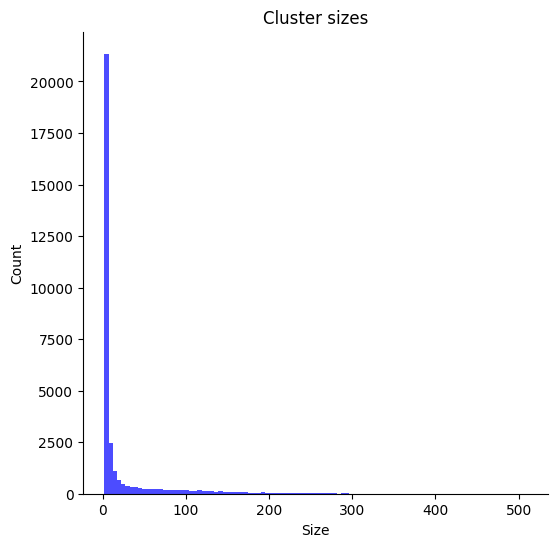

In [4]:
import numpy as np 
from tqdm import tqdm 
from utils import get_temporal_range
mode = 'equal'
resolution = 100
# WEIGHTS_ECO = list({'ws': 2, 'wt': 1.5, 'we': 1, 'wc': 2}.values())
# WEIGHTS_PCA = list({'ws': 0.40759976, 'wt': 0.23017731, 'we': 0.20566699, 'wc': 0.15655594}.values())

# #add one attribute to all edges
# for u, v, d in G.edges(data=True):
#     if dim == 4:
#         lweights = [d['ws'], d['wt'], d['we'], d['wc']]
#     elif dim == 2:
#         lweights = [d['ws'], d['wt']]
#     if mode == 'equal':
#         d['weight'] = np.mean(lweights)
#     elif mode == 'PCA':
#         d['weight'] = np.average(lweights, weights=WEIGHTS_PCA[:dim])
#     elif mode == 'eco':
#         d['weight'] = np.average(lweights, weights=WEIGHTS_ECO[:dim])

communities = nx.community.louvain_communities(G, seed=0, resolution=resolution)

# Create a list to store the sub-GeoDataFrames
island_gdfs = []

print(f'Building islands with resolution {resolution}...')
# Iterate over each island and create a sub-GeoDataFrame
for island in tqdm(communities):
    # Select rows from the original GeoDataFrame that correspond to the current island
    island_gdf = attribution.dataset.iloc[list(island)]
    
    # Append this sub-GeoDataFrame to the list
    island_gdfs.append(island_gdf)

for i, island_gdf in tqdm(enumerate(island_gdfs)):
    # Calculate the envelope (bounding box) of the cluster
    envelope = island_gdf.unary_union.envelope

    # Calculate the temporal range of the cluster
    cluster_start, cluster_end = get_temporal_range(island_gdf)

    # Find potential matches using spatial index
    possible_matches_index = list(spatial_entity_sindex.intersection(envelope.bounds))
    possible_matches = spatial_entity_dataset.iloc[possible_matches_index]

    if len(possible_matches_index) > 0 :
        break
    # Initialize an empty list to store events to be added
    events_to_add = []

    # Iterate through each potential match
    for event in possible_matches.itertuples(index=True):
        # Check spatial intersection
        spatial_condition = envelope.intersects(event.geometry)
        # Check temporal intersection
        event_start = event.start_date  # Replace with your actual column name
        event_end = event.end_date
        temporal_condition = ((event_start <= cluster_end + temporal_threshold_) and (event_end >= cluster_end - temporal_threshold_)) or ((event_start <= cluster_start + temporal_threshold_) and (event_end >= cluster_start - temporal_threshold_)) 

        # If both conditions are met, add the event to the list
        if spatial_condition and temporal_condition:
            events_to_add.append(event.Index)

    # Add the events to the cluster GeoDataFrame
    if len(events_to_add) > 0:
        additional_events = attribution.spatial_entity_dataset.loc[events_to_add]
        island_gdfs[i] = gpd.GeoDataFrame(pd.concat([island_gdf, additional_events]), geometry='geometry', crs=island_gdf.crs)

# Initialize an empty list to store the modified cluster GeoDataFrames          
modified_gdfs = []

# Add a 'cluster' column and concatenate
for i, island_gdf in tqdm(enumerate(island_gdfs)):
    island_gdf['cluster'] = i  # Add a 'cluster' column with the cluster index
    modified_gdfs.append(island_gdf)


# Ensure the GeoDataFrame has the correct geometry set
all_clusters_gdf = gpd.GeoDataFrame(pd.concat(modified_gdfs), geometry='geometry').drop(columns=['year'])

# Save to GeoParquet
c = all_clusters_gdf.shape[0] / (spatial_entity_dataset.shape[0] + dataset.shape[0] )
all_clusters_gdf.to_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

print(f'conversion rate : {c :.2%}')

##metrics##
island_sizes = all_clusters_gdf.cluster.value_counts().tolist()
median = np.median(island_sizes)
std = np.std(island_sizes)
print(f'median : {median}, std : {std}')


median : 4.0, std : 39.092321139365914


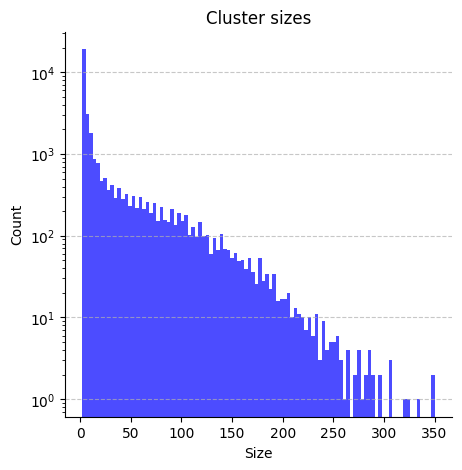

In [11]:
resolution = 100
all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

##metrics##
island_sizes = all_clusters_gdf.cluster.value_counts().tolist()
median = np.median(island_sizes)
std = np.std(island_sizes)
print(f'median : {median}, std : {std}')


import matplotlib.pyplot as plt
# Plot the histogram
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.hist(island_sizes, bins=100, color='blue', alpha=0.7, log=True)
ax.set_title('Cluster sizes')
ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

In [8]:
fig.savefig(f'../figures/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.png', dpi=300)